# Final Project

___

### Overview:

* **Name**:  Henry Chan
* **Project theme**:  Tree Health in New York (2015)

<br>

### Purpose:

* The purpose of the project is to classify tree health.
* The dependent variable (DV) will be `health`, which contains string values of `Good`, `Fair` and `Poor`.
* There are 40 independent variables (IV). Some of them are geographical variables which I will not be using for analysis. 
* I will only focus on related IV, for example:
    - `tree_dbh`: Diameter of the tree
    - `curb_loc`: Location of tree bed in relationship to the curb
    - `status`: Alive, standing dead, or a stump
    - `spc_common`: Common name for species
    - `sidewalk`: Indicates whether one of the sidewalk flags immediately adjacent to the tree was damaged
    - `problems`: Problems of the tree
    - `root_stone`: Indicates the presence of a root problem caused by paving stones in tree bed
    - `trunk_wire`: Indicates the presence of a trunk problem caused by wires or rope wrapped around the trunk
    - `brch_light`: Indicates the presence of a branch problem caused by lights
    - etc...
* There is a total of 652,169 records (230MB) in the `.csv` file. Down-sizing and resampling would be considered for convenience.
<br>

### Dataset source:

The dataset is provided by City of New York and can be downloaded [here](https://catalog.data.gov/dataset/2015-street-tree-census-tree-data).

The census is conducted in 2015 by volunteers and staffs from NYC Parks & Recreation.

<br>


### Preliminary results:

In [1]:
# import packages for data cleaning and visualisation
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

# import my module
from clean_tree import read_tree, alive_tree
import description as des
import machine_learning as ml

#### Data cleaning

In [2]:
# import cleaned dataset
trees_alive =  alive_tree(read_tree())

Number of NAs: 0. Shape of cleaned dataset: (652118, 42)


#### Data description

There are so many tree spcies planted in NYC. It might be interesting to investigate the behaviour among species,

that is to ask whether some species is more healthy than the others.

To do so, the most commonly seen tree species (which each specie has more than 10k in the dataset) 

in NY is filtered out as the dataset of interest,

and a heatmap is used to see if there is any uneven distribution among their health condition.

In [3]:
# get dataset of common trees
common_trees = des.get_common_tree(trees_alive)
# get crosstab against health
crosstab = pd.crosstab(
        common_trees["health"], 
        common_trees["spc_common"], 
        normalize='columns')

In [4]:
# visualise using ploty
fig = px.imshow(crosstab, text_auto='.3f', color_continuous_scale='RdBu')
fig.update_xaxes(title = "Tree Species")
fig.update_yaxes(title = "Health")
fig.show()

As it is obvious from the above heatmap, 

`Norway maple` is have a higher percentage of poor health when compared to the other species.

To check if this high percentage is statistically significant,

a proportion z-test is performed to compared the poor health proportion among `Normay maple` and its conterpart.

It is found that at $\alpha$=0.01 level, null hypothesis is rejected ($\Z$ = 72.3, p=0.000) and therefore 

`Norway maple` is said to be particularly poor in health condition compared to other species.

In [5]:
# perform proportion z-test on distribution of health for Norway maple
des.prop_z_test(common_trees, "Norway maple")

Norway maple   False   True     All
health                             
Good          446775  30410  477185
Poor           15181   3779   18960
All           461956  34189  496145 

Z-score = 72.3, p = 0.0.
0.0 < 0.01, the null hypothesis is rejected.


The following heatmaps show the nomalised (per `health`) contingency table between labels (i.e. `health`) and IVs. 

Heatmaps like `brnch_othe` (have branch poroblem with other reasons) vs `health` show a significant contrast in color along the vertical axis, 

which may indicate an association between IVs and label.

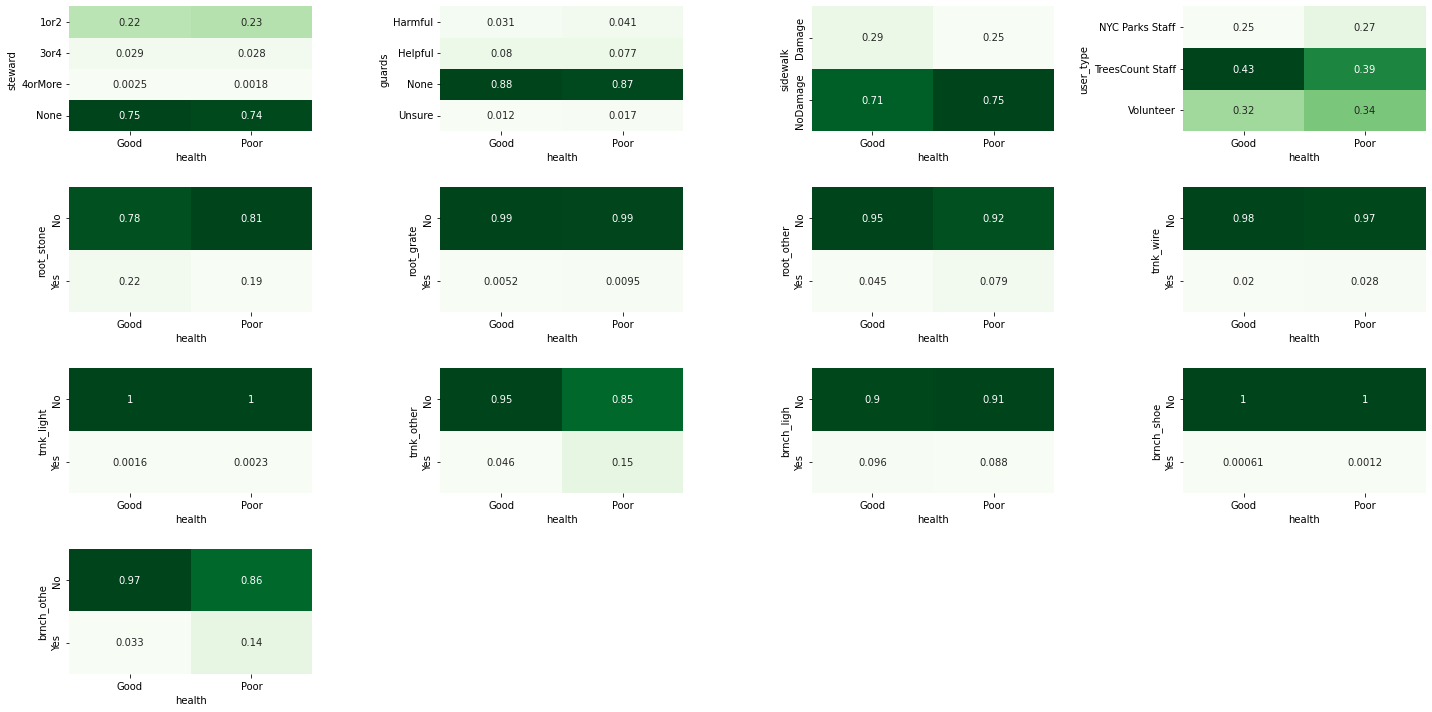

In [6]:
# select categorical features for analysis
target_ivs = ['steward', 'guards', 'sidewalk', 'user_type', 'root_stone',
       'root_grate', 'root_other', 'trnk_wire', 'trnk_light', 'trnk_other',
       'brnch_ligh', 'brnch_shoe', 'brnch_othe']

# plot heatmaps for each categorical features against health
des.contingency_heatmap(trees_alive, target_ivs, "health")
plt.show()

### Hypothesis testing result:

Based on the result from the above heatmap(bottom-left), chi-square test of independence is conducted holding the null hypothesis that 

health and branch problems (due to other reasons) are independent to each other. 

It is found that at $\alpha$=0.01 level, null hypothesis is rejected ($\chi^2$ = 7630, p=0.000) and therefore 

tree health is not independent with branch problems (due to other reasons).

The following grpah shows the contribution per population to chi-square.

In particular, trees with poor condition seemingly associate more to having branch problems(due to other reasons). 

In [7]:
des.independence_test(trees_alive, "brnch_othe", alpha=0.01)

health        Good   Poor
brnch_othe               
No          604605  23158
Yes          20697   3658 

Chi-square = 7.63e+03, p = 0.0.
0.0 < 0.01, the null hypothesis is rejected.


### Machine learning result:

In [8]:
# extract test and train data
x_train, x_test, y_train, y_test = ml.extract_train_test_data(trees_alive, target_ivs)

Shape of feature dataset:(652118, 18). Shape of label dataset: (652118,)
TProportion of labels: 
 0    0.958879
1    0.041121
dtype: float64


Decision Tree Classifier is used to classify `health` (i.e. `Healthy` or `Poor`) using the above categorical IVs. 

The desison tree classifier shows a performace of f1-score = 0.15

As shown in the following graph, the previously tested `brnch_othe` shows significant feature importance i.e. contribution to model.

Confusion matrix: 
 [[121388   3673]
 [  4629    734]]
Test f1 score for decision tree model is 0.15


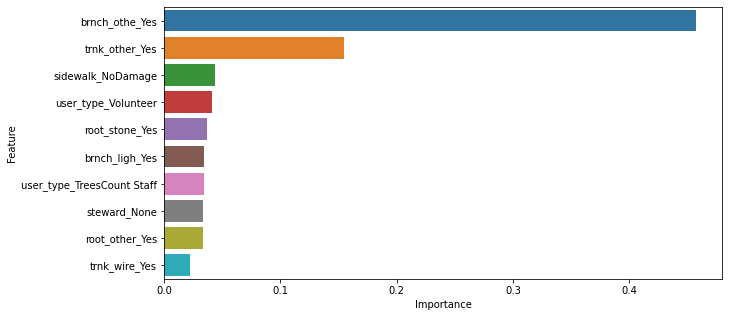

In [9]:
from sklearn.tree import DecisionTreeClassifier

# train a decision tree model and evaluate its performance
dt = ml.dt_model_report(DecisionTreeClassifier, x_train, x_test, y_train, y_test)

To make a comparison, a categorical Naive Bayes model is also used to 

classify `health` (i.e. `Healthy` or `Poor`) using the above categorical IVs. 

The  Naive Bayes model shows a performace of f1-score = 0.134, 

which is similar to that of decision tree classifier.

However, to further investigate the difference between the two models,

precision-recall curve is used and shown below.

It is found that decision tree model have a better general performance on both

precision and recall.

In [10]:
from sklearn.naive_bayes import CategoricalNB

# train a categorical Naive Bayes model and evaluate its performance
nb = ml.nb_model_report(CategoricalNB, x_train, x_test, y_train, y_test)

Confusion matrix: 
 [[111733  13328]
 [  4017   1346]]
Test f1 score for categorical naive bayes is 0.134


Preision-Recall curve for decision tree model:


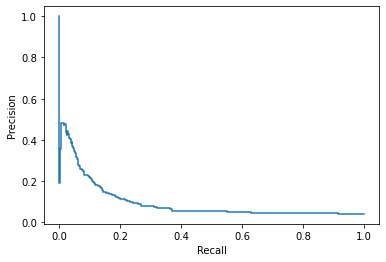

In [11]:
# plot precision-recall curve for decision tree model
print("Preision-Recall curve for decision tree model:")
ml.pr_curve(dt, x_test, y_test)

Preision-Recall curve for categorical Naive Bayes model:


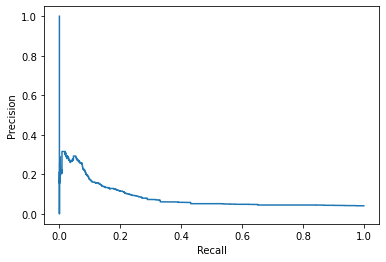

In [12]:
# plot precision-recall curve for categorical Naive Bayes model
print("Preision-Recall curve for categorical Naive Bayes model:")
ml.pr_curve(nb, x_test, y_test)